In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
# Load the accept-reject data
filename_accept_reject_monash = '/home/tonym/Code/tuning_data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
pgun_accept_reject_monash = np.load(filename_accept_reject_monash, mmap_mode = "r")
filename_accept_reject_island = '/home/tonym/Code/tuning_data/pgun_qqbar_accept_reject_z_a_1.5_b_0.6_sigma_0.335_N_1e5.npy'
pgun_accept_reject_island = np.load(filename_accept_reject_island, mmap_mode = "r")
# Load the hadron data
filename_hadrons_monash = '/home/tonym/Code/tuning_data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
pgun_hadrons_monash = np.load(filename_hadrons_monash, mmap_mode="r")
filename_hadrons_island = '/home/tonym/Code/tuning_data/pgun_qqbar_hadrons_a_1.5_b_0.6_sigma_0.335_N_1e5.npy'
pgun_hadrons_island = np.load(filename_hadrons_island, mmap_mode="r")

In [3]:
print("Accepted and rejected z data shape (Monash):", pgun_accept_reject_monash.shape)
print("Hadron data shape (Monash):", pgun_hadrons_monash.shape)
print("Accepted and rejected z data shape (Island):", pgun_accept_reject_island.shape)
print("Hadron data shape (island):", pgun_hadrons_island.shape)

Accepted and rejected z data shape (Monash): (100000, 50, 100)
Hadron data shape (Monash): (100000, 50, 5)
Accepted and rejected z data shape (Island): (100000, 50, 100)
Hadron data shape (island): (100000, 50, 5)


In [13]:
print(pgun_accept_reject_monash[0])
print(pgun_accept_reject_monash[0,:,0][pgun_accept_reject_monash[0,:,0] > 0.0])

[[0.0686964 0.874901  0.920626  ... 0.        0.        0.       ]
 [0.395404  0.359597  0.32135   ... 0.        0.        0.       ]
 [0.322769  0.742624  0.116491  ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
[0.0686964 0.395404  0.322769  0.720002  0.256514  0.349795  0.219633
 0.0925937 0.0360868 0.148006  0.121184  0.0981008 0.16814   0.162872
 0.138534  0.24237   0.655707  0.459163  0.456206  0.045958 ]


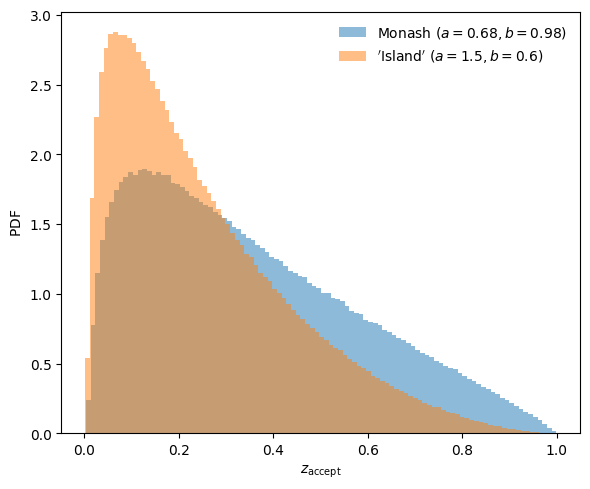

In [11]:
# Histrogram all accepted z-values across all events
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.hist(pgun_accept_reject_monash[:,:,0][pgun_accept_reject_monash[:,:,0] > 0.0], 100, alpha = 0.5, density = True, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$')
ax.hist(pgun_accept_reject_island[:,:,0][pgun_accept_reject_island[:,:,0] > 0.0], 100, alpha = 0.5, density = True, label = r"$\mathrm{'Island'}$ $(a = 1.5, b = 0.6)$")
ax.set_xlabel(r'$z_{\mathrm{accept}}$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False)
fig.tight_layout()

In [18]:
# Collect multiplicity data
mult_monash = np.array([len(pgun_hadrons_monash[i,:][pgun_hadrons_monash[i,:,0] > 0.0]) for i in range(pgun_hadrons_monash.shape[0])])
mult_island = np.array([len(pgun_hadrons_island[i,:][pgun_hadrons_island[i,:,0] > 0.0]) for i in range(pgun_hadrons_island.shape[0])])

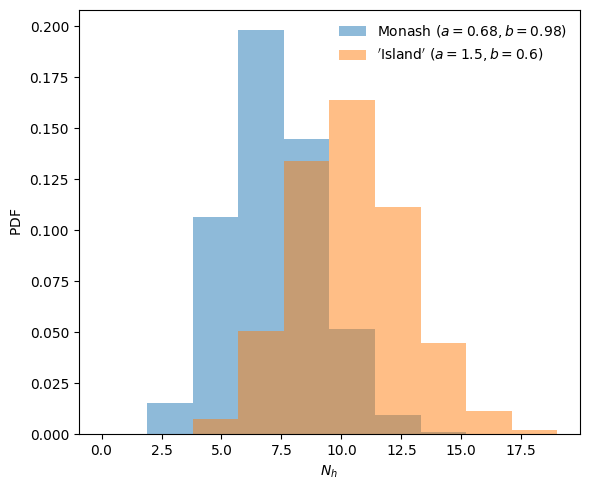

In [16]:
# Histrogram hadron multiplicity
fig, ax = plt.subplots(1,1,figsize=(6,5))
_, bins, _ = ax.hist(mult_monash, alpha = 0.5, density = True, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$')
ax.hist(mult_island, bins = bins, alpha = 0.5, density = True, label = r"$\mathrm{'Island'}$ $(a = 1.5, b = 0.6)$")
ax.set_xlabel(r'$N_h$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False)
fig.tight_layout()

In [19]:
# The reweighting module
class Reweighter(nn.Module):
    def __init__(self, params_base, params, over_sample_factor=10.):
        super(Reweighter, self).__init__()
        self.params_base = params_base
        self.params_a = torch.nn.Parameter(params[0].clone(), requires_grad=True)
        self.params_b = torch.nn.Parameter(params[1].clone(), requires_grad=True)
        self.over_sample_factor = over_sample_factor
    
    def zMaxCalc(self, a, b, c):
        # Superfluous constants
        AFROMZERO = 0.02
        AFROMC = 0.01
        
        # Normalization for Lund fragmentation function so that f <= 1.
        # Special cases for a = 0 and a = c.
        aIsZero = (a < AFROMZERO)
        aIsC = (torch.abs(a - c) < AFROMC)
        # Determine position of maximum.
        if aIsZero:
            return b / c if c > b else 1.
        elif aIsC:
            return b / (b + c)
        else:
            zMax = 0.5 * (b + c - torch.sqrt((b - c)**2 + 4 * a * b)) / (c - a)
            # Grab indicies for special condition
            # Assuming zMax, a, and b are PyTorch tensors of the same shape
            zMax = torch.where((zMax > 0.9999) & (b > 100.), torch.min(zMax, 1. - a / b), zMax)
            return zMax
    
    def likelihood(self, z, mT, a, b, c = torch.tensor(1.)):
        """
        Compute the likelihood of the Lund fragmentation function
        """
        CFROMUNITY = 0.01
        AFROMZERO = 0.02
        AFROMC = 0.01
        EXPMAX = 50
        b_exp = b * torch.pow(mT, 2)
        # Special cases for c = 1, a = 0 and a = c.
        cIsUnity = (abs(c - 1.) < CFROMUNITY)
        aIsZero = (a < AFROMZERO)
        aIsC = (abs(a - c) < AFROMC)
        # Determine position of maximum.
        zMax = self.zMaxCalc(a, b_exp, c)
        aCoef = torch.log((1. - z) / (1. - zMax))
        bCoef = (1. / zMax - 1. / z)
        cCoef = torch.log(zMax / z)
        fExp = b_exp * bCoef + c * cCoef
        if not aIsZero:
            fExp += a * aCoef
        fVal = torch.exp(torch.clamp(fExp, min=-EXPMAX, max=EXPMAX))
        return fVal

    def forward(self, z, mT, observable):
        """
        Forward pass of the weight module -- consists of computing the event weights for a given batch
        of training data.
        """
        batch_size = z.shape[0]
        weights = torch.ones(batch_size)
    
        # Vectorizing the processing as much as possible (still room for improvement)
        for i in range(batch_size):
            # Multiplicity of event in batch
            event_mult = int(observable[i, 0])
            # Process accepted values
            accept_indices = z[i, :event_mult, 0] != 0.
            accept_tensor = z[i, :event_mult, 0][accept_indices]
            accept_mT = mT[i, :event_mult][accept_indices]
            accept_weights = self.likelihood(accept_tensor, accept_mT, self.params_a, self.params_b) / self.likelihood(accept_tensor, accept_mT, self.params_base[0], self.params_base[1])
            
            # Process rejected values
            reject_tensor = z[i, :event_mult, 1:]
            reject_weights = torch.ones(event_mult)
            for j in range(event_mult):
                reject_values = reject_tensor[j, reject_tensor[j, :] != 0.]
                if reject_values.numel() > 0:
                    reject_weights_i = (self.over_sample_factor - self.likelihood(reject_values, mT[i, j], self.params_a, self.params_b)) / (self.over_sample_factor - self.likelihood(reject_values, mT[i, j], self.params_base[0], self.params_base[1]))
                    reject_weights[j] = torch.prod(reject_weights_i)
    
            # Compute event weight
            event_weight = torch.prod(accept_weights) * torch.prod(reject_weights)
            weights[i] = event_weight
    
        return weights

In [20]:
# Define a new transverse mass array
pgun_mT_island  = np.sqrt(pgun_hadrons_island[:, :, 0]**2 + pgun_hadrons_island[:, :, 1]**2 + pgun_hadrons_island[:, :, 4]**2)

In [24]:
print(pgun_hadrons_island[0])
print(np.sqrt(pgun_hadrons_island[0,0,0]**2 + pgun_hadrons_island[0,0,1]**2 + pgun_hadrons_island[0,0,4]**2))
print(pgun_mT_island[0])

[[-1.96636e-02 -2.71647e-01 -4.02237e+00  4.03399e+00  1.39570e-01]
 [ 1.40079e-02  1.97556e-01  4.25643e+01  4.25650e+01  1.39570e-01]
 [ 1.08771e-02  3.70284e-01 -6.55989e+00  6.57183e+00  1.39570e-01]
 [ 4.09029e-02 -4.25095e-01  4.31213e+00  4.33533e+00  1.34980e-01]
 [-5.29810e-01  2.49196e-02  6.08975e-01  8.18774e-01  1.34980e-01]
 [ 6.42883e-01  3.18075e-01  5.72590e-01  9.27658e-01  1.34980e-01]
 [ 5.36570e-01 -2.83368e-01 -8.73892e+00  8.76100e+00  1.34980e-01]
 [-3.69625e-01  1.29771e-01  2.51200e-01  4.85844e-01  1.39570e-01]
 [ 3.05155e-01 -5.14495e-01  5.69570e-01  8.37684e-01  1.39570e-01]
 [-4.12878e-01  7.95625e-01 -8.93370e+00  8.97964e+00  1.39570e-01]
 [-7.41088e-02  3.29532e-01 -1.49621e-01  3.94905e-01  1.39570e-01]
 [-1.96080e-01 -1.93870e-01 -1.76392e+00  1.79079e+00  1.39570e-01]
 [-1.38583e-01 -1.32872e-01 -1.98782e-01  3.09604e-01  1.39570e-01]
 [ 1.95161e-01 -5.21564e-01 -1.73796e+00  1.83033e+00  1.39570e-01]
 [ 2.84012e-01  1.49463e-01 -1.39054e+00  1.4339

In [ ]:
# Set parameters
base_params = 

# Initialize the reweighting module
reweighter = 